# Example Notebook
Author: Charles Gannon

Contact: cgannon@ucmerced.edu

## Introduction
The ```subscript``` python package provides a library of ergonomic utility functions for analyzing Galacticus (https://github.com/galacticusorg/galacticus) subhalo data. This notebook provides an introduction to the functionality provided in this package. More examples are provided in the test folder. 

# Installation 

### Install via pip
```pip install subhaloscript```

### Install via conda
```conda install cgannonucm::subhaloscript```

## Data From File
```subscript``` integrates with h5py

In [1]:
import h5py
gout = h5py.File('data/test.hdf5')

## Node Data
In Galacticus each subhalo is represented as a node on the primary halo's merger tree. To access properties of each node, use the ```nodedata``` function. Galacticus can contain multiple trees in a single output file, subscript automatically seperates the output nodes into their respective trees.

In [2]:
from subscript.scripts.nodes import nodedata

mass = nodedata(gout, key='basicMass')

# The infall mass of the first 5 subhalos in the 1st galacticus output tree
print(mass[0][:5])

# The infall mass of the first 5 subhalos in the 2nd galacticus output tree
print(mass[1][:5])

[7.21810428e+09 1.49945391e+09 3.45035586e+09 3.10940712e+09
 2.28942716e+10]
[2.51769675e+09 6.33693813e+09 1.88133845e+09 1.02403051e+09
 1.48554503e+09]


Multiple keys can be passed at once

In [3]:
import numpy as np
mass_basic, mass_bound = nodedata(gout, key=['basicMass', 'massBound'])[0]
mass_ratio = np.mean(mass_bound/mass_basic)

# The average mass at infall to bound masss for the first tree
print(mass_ratio)

0.5666598142807098


Count number of nodes

In [4]:
from subscript.scripts.nodes import nodecount

# Average number of nodes per tree
print(np.mean(nodecount(gout)))

246.05357142857142


## Filters
```subscript``` supports filtering nodes by passing a ```nfilter``` function or numpy array of booleans.

In [5]:
# Get the average host halo mass
import subscript.scripts.nfilters as nf
# Only include host halo nodes
host_halo_mass = nodedata(gout, key='basicMass', nfilter=nf.hosthalos)

# Log 10 of average host halo mass
print(np.log10(np.mean(host_halo_mass)))

13.0


### Combining filters

Filters can be combined or modified using boolean logic. We can use the ```logical_and``` or ```logical_not``` function to combine two filters or the ```logical_not``` function to invert the filter.

In [6]:
from subscript.scripts.spatial import project3d
# Only get subhalos within 50 kpc of the host 
# Note ```subscript``` uses default units of galacticus which is MPC
filter_combined = nf.logical_and(
                                    nf.subhalos,
                                    nf.r3d(None, 0, 5E-2) # Passing 'None' as a first argument 'freezes' the filter, saving the key word arguments
                                )

# Now we have no subhalos outside of 0.05 MPC from the center of the host
print(np.max(project3d(gout, nfilter=filter_combined)[0]))  

0.04988945595354875


## Statistical Analysis

Perform statistical analysis over multiple trees by passing the argument ```summarize=true``` and optionally pass a list of functions, for statistical analysis passing the ```statfuncs``` argument. The default option is ```statfuncs=[np.mean]```, but if the standard deviation is required, you can pass ```statfuncts=[np.mean, np.std]```

[]

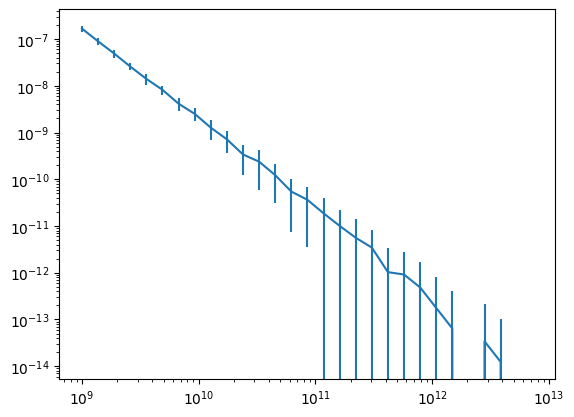

In [7]:
# Subhalo massfunction
from subscript.scripts.histograms import massfunction
# Provides galacticus default parameter keys
from subscript.defaults import ParamKeys
import matplotlib.pyplot as plt


out = massfunction(
                    gout,
                    bins=np.logspace(9, 13, 30), 
                    key_mass = ParamKeys.mass_bound,    # The default key for bound mass of the subhalo
                    nfilter=nf.subhalos,                # Only consider subhalos 
                    summarize=True,                     # Take statistics over multiple trees
                    statfuncs=[np.mean, np.std]         # Get the mean and std
                   )

dndm_mean, mbine = out[0]
dndm_std , _     = out[1]

#  Plot the mean mass function over all trees, show the standard deviation at each point
plt.errorbar(mbine[:-1], dndm_mean, dndm_std)
plt.loglog()

### Custom Analysis Functions

Use the ```gscript``` decerator to create analysis functions

In [8]:
from subscript.wrappers import gscript

# Custom analysis function to take the ratio between bound and infall mass
@gscript
def massratio_avg(gout, **kwargs):
    return np.mean(gout[ParamKeys.mass_bound] / gout[ParamKeys.mass_basic])

# Average bound to infall mass ratio
print(massratio_avg(gout, nfilter=nf.subhalos, summarize=True))

0.5539299558467177
